In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'link_to_transcript',
        root = '..',
        default_wildcards={'library_prep': 'cDNA', 'platform': 'PacBio', 'counting': 'end'}
    )

In [2]:
import functools
import numpy as np
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
from lapa.result import LapaResult
from lapa.utils.io import read_talon_read_annot

In [3]:
result = LapaResult(snakemake.input['quantseq_lapa_dir'], tpm_cutoff=0)

df_quantseq = result.read_cluster().drop_duplicates(
    subset=['Chromosome', 'polyA_site', 'Strand'])
df_quantseq['Start'] = df_quantseq['polyA_site'] - 1
df_quantseq['End'] = df_quantseq['polyA_site']

gr_quantseq = pr.PyRanges(df_quantseq, int64=True)

In [4]:
gr_cage = functools.reduce(
    lambda gr_x, gr_y: gr_x.merge(gr_y),
    [pr.read_bed(i) for i in snakemake.input['cage']]
)
gr_cage = pr.PyRanges(gr_cage.df, int64=True)

In [5]:
df_links = pd.read_csv(snakemake.input['links']) \
    .astype({'polyA_site': 'int', 'start_site': 'int'})

In [6]:
df_abundance = pd.read_csv(snakemake.input['abundance'], sep='\t')

In [7]:
df_reads = read_talon_read_annot(snakemake.input['read_annot'])[[
    'Chromosome', 'Strand', 'transcript_id', 'read_name']]

In [8]:
df_reads = df_reads[df_reads['transcript_id'].isin(df_abundance['annot_transcript_id'])]

In [9]:
df = df_reads.set_index('read_name').join(
    df_links.set_index('read_name')[
        ['read_Start', 'read_End', 'start_site', 'polyA_site']
    ], how='inner')

# df = df[(df['start_site'] != -1) & (df['polyA_site'] != -1)]

In [10]:
df

,Chromosome,Strand,transcript_id,read_Start,read_End,start_site,polyA_site
read_name,,,,,,,
m54284U_201023_135811/657715/ccs,ERCC-00002,+,human_WTC11_cDNA_PacBio_longT000237014,1,1043,2,1043
m54284U_201023_135811/1245744/ccs,ERCC-00002,+,human_WTC11_cDNA_PacBio_longT000237014,1,1043,2,1043
m54284U_201023_135811/1378501/ccs,ERCC-00002,+,human_WTC11_cDNA_PacBio_longT000237014,1,1044,2,1043
m54284U_201023_135811/1769949/ccs,ERCC-00002,+,human_WTC11_cDNA_PacBio_longT000237014,1,1045,2,1043
m54284U_201023_135811/3345068/ccs,ERCC-00002,+,human_WTC11_cDNA_PacBio_longT000237014,1,1043,2,1043
...,...,...,...,...,...,...,...
m54284U_201123_202240/71566296/ccs,chr22,+,ENST00000462238.5,50783817,50799178,50783797,50799178
m54284U_201028_155127/45155970/ccs,chr22,+,ENST00000462238.5,50783819,50799171,50783797,50799178
m54284U_201121_072510/6031995/ccs,chr22,+,ENST00000651346.1,50783828,50799178,50783797,50799178


In [11]:
df_linked = df.groupby(['Chromosome', 'transcript_id', 'start_site', 'polyA_site', 'Strand']) \
    .size().reset_index().rename(columns={0: 'count'})

In [12]:
df_linked['End'] = df_linked['start_site']
df_linked['Start'] = df_linked['End'] - 1

In [13]:
gr_cage.cage_support = True

In [14]:
gr_quantseq = gr_quantseq.drop()
gr_quantseq.polya_support = True

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
_df = pr.PyRanges(df_linked, int64=True).join(gr_cage, how='left') \
    .df.drop(columns=['End', 'Start', 'Start_b','End_b', 'Strand_b'])

In [17]:
_df['End'] = _df['polyA_site']
_df['Start'] = _df['End'] - 1

In [18]:
_df

,Chromosome,transcript_id,start_site,polyA_site,Strand,count,cage_support,End,Start
0,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,2,156,+,6,-1,156,155
1,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,2,215,+,7,-1,215,214
2,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,2,1043,+,18574,-1,1043,1042
3,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,337,1043,+,184,-1,1043,1042
4,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,415,1043,+,194,-1,1043,1042
...,...,...,...,...,...,...,...,...,...
248259,chrY,human_WTC11_cDNA_PacBio_longT000588235,19744722,19705419,-,7,-1,19705419,19705418
248260,chrY,human_WTC11_cDNA_PacBio_longT000588235,19744722,19705601,-,1,-1,19705601,19705600
248261,chrY,human_WTC11_cDNA_PacBio_longT000588235,19744918,19705419,-,1,-1,19705419,19705418
248262,chrY,human_WTC11_cDNA_PacBio_longT000588253,19744722,19705419,-,3,-1,19705419,19705418


In [19]:
df = pr.PyRanges(_df, int64=True).join(gr_quantseq, how='left').df \
    .drop(columns=['End', 'Start', 'Start_b','End_b', 'Strand_b'])

In [20]:
df

,Chromosome,transcript_id,start_site,polyA_site,Strand,count,cage_support,polya_support
0,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,2,156,+,6,-1,-1
1,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,2,215,+,7,-1,-1
2,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,2,1043,+,18574,-1,-1
3,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,337,1043,+,184,-1,-1
4,ERCC-00002,human_WTC11_cDNA_PacBio_longT000237014,415,1043,+,194,-1,-1
...,...,...,...,...,...,...,...,...
248293,chrY,human_WTC11_cDNA_PacBio_longT000588218,19744722,19705485,-,1,-1,-1
248294,chrY,human_WTC11_cDNA_PacBio_longT000588218,19744722,19705601,-,2,-1,-1
248295,chrY,human_WTC11_cDNA_PacBio_longT000588225,-1,19705485,-,1,-1,-1
248296,chrY,human_WTC11_cDNA_PacBio_longT000588235,19744722,19705601,-,1,-1,-1


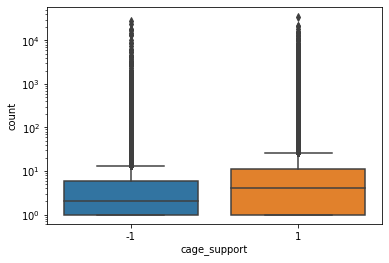

In [21]:
import seaborn as sns

sns.boxplot(data=df, x='cage_support', y='count')
plt.yscale('log')

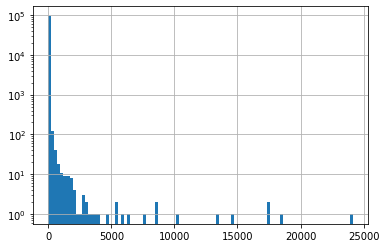

In [22]:
df[(df['cage_support'] == -1) & (df['polya_support'] == -1)]['count'].hist(bins=100)
plt.yscale('log')

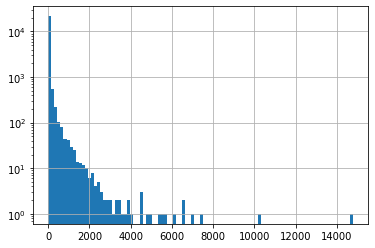

In [23]:
df[(df['cage_support'] != -1) & (df['polya_support'] != -1)]['count'].hist(bins=100)
plt.yscale('log')

In [24]:
df_links['End'] =  df_links['start_site']
df_links['Start'] = df_links['End'] - 1

In [25]:
df[(df['cage_support'] != -1) & (df['polya_support'] != -1)].shape

(22721, 8)

In [26]:
df[(df['cage_support'] == -1) & (df['polya_support'] == -1)].shape

(94405, 8)

In [27]:
df[(df['cage_support'] != -1) | (df['polya_support'] != -1)].shape

(153893, 8)

In [30]:
df.shape

(248298, 8)

In [29]:
df_link_cage = pr.PyRanges(df_links).nearest(gr_cage, how='inner').df

ValueError: Buffer dtype mismatch, expected 'const int64_t' but got 'int'

In [ ]:
df_link_cage = df_link_cage[df_link_cage['Distance']  < 50]

In [ ]:
df_link_cage['End'] =  df_link_cage['polyA_site']
df_link_cage['Start'] = df_link_cage['End'] - 1

In [ ]:
df_link_cage_polya = pr.PyRanges(df_link_cage).nearest(gr_quantseq, how='inner').df

In [ ]:
df_link_cage_polya = df_link_cage_polya[df_link_cage_polya['Distance_b'] < 50]

In [ ]:
df_link_cage_polya.shape

In [ ]:
df_reads.head()

In [ ]:
df_link_counts = df_links.groupby(['Chromosome', 'start_site', 'polyA_site']) \
    .size().reset_index().rename(columns={0: 'count'})

In [ ]:
df_link_counts = df_link_counts[
    (df_link_counts['start_site'] != -1) & 
    (df_link_counts['polyA_site'] != -1)
]

In [ ]:
df_link_counts['count'].sum() / df_reads.shape[0]

In [ ]:
df_join = df_reads.set_index('read_name').join(
    df_links.set_index('read_name')[['start_site', 'polyA_site']], how='inner')

In [ ]:
df_join[(df_join['start_site'] == -1) & (df_join['polyA_site'] == -1)]

In [ ]:
len(set(df_reads['read_name']).intersection(df_links['read_name']))

In [ ]:
df_join

In [ ]:
df_join = df_join[(df_join['start_site'] != -1) & (df_join['polyA_site'] != -1)]

In [ ]:
df_transcript_site = df_join.groupby(['transcript_id', 'start_site', 'polyA_site']) \
    .size().reset_index().rename(columns={0: 'count'})

In [ ]:
num_transcript = df_transcript_site[df_transcript_site['count'] > 5].groupby('transcript_id').size()

In [ ]:
sum(num_transcript - 1)

In [ ]:
len(df_reads['transcript_id'].unique())

In [ ]:
df_abundance = pd.read_csv(snakemake.input['abundance'], sep='\t')

In [ ]:
len(df_abundance['annot_transcript_id'].unique())

In [ ]:
num_transcript[num_transcript.isin(df_abundance['annot_transcript_id'].unique())]

In [ ]:
(num_transcript[num_transcript.index.isin(set(df_abundance['annot_transcript_id'].unique()))] - 1).sum()